In [111]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats
import numpy as np
from math import sqrt

In [112]:
def CalcRSquared(observed, estimated):
    """Calculate the r^2 from a series of observed and estimated target values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    r, p = scipy.stats.pearsonr(observed, estimated)
    R2 = r **2
    
    return R2

def CalcRMSE(observed, estimated):
    """Calculate Root Mean Square Error between a series of observed and estimated values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    res = (observed -estimated)**2
    RMSE = round(sqrt(res.mean()), 3)
    
    return RMSE

# Data Wrangling

In [113]:
london_OD_AMpeak = pd.read_csv("london_flows.csv")

In [114]:
london_OD_AMpeak

,station_origin,station_destination,flows,population,jobs,distance
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097
1,Abbey Road,Beckton,1,599,442,8510.121774
2,Abbey Road,Blackwall,3,599,665,3775.448872
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220
4,Abbey Road,Canning Town,37,599,15428,2228.923167
...,...,...,...,...,...,...
61469,Woolwich Arsenal,Tower Gateway,127,7892,3342,13401.795549
61470,Woolwich Arsenal,West Ham,608,7892,5487,8701.454361
61471,Woolwich Arsenal,West India Quay,6,7892,400,9536.720451
61472,Woolwich Arsenal,West Silvertown,81,7892,893,5355.248554


TEST

In [115]:
#first we create a new total column which excludes intra-borough flow totals (we will set them
#to a very small number for reasons you will see later)
london_OD_AMpeak["FlowsNoIntra"] = london_OD_AMpeak.apply(lambda x: 0 if x['station_origin'] == x['station_destination'] else x['flows'], axis=1)

In [116]:
london_OD_AMpeak

,station_origin,station_destination,flows,population,jobs,distance,FlowsNoIntra
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,0
1,Abbey Road,Beckton,1,599,442,8510.121774,1
2,Abbey Road,Blackwall,3,599,665,3775.448872,3
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,1
4,Abbey Road,Canning Town,37,599,15428,2228.923167,37
...,...,...,...,...,...,...,...
61469,Woolwich Arsenal,Tower Gateway,127,7892,3342,13401.795549,127
61470,Woolwich Arsenal,West Ham,608,7892,5487,8701.454361,608
61471,Woolwich Arsenal,West India Quay,6,7892,400,9536.720451,6
61472,Woolwich Arsenal,West Silvertown,81,7892,893,5355.248554,81


In [117]:
#set the number to a very small number
# cdata["offset"]= cdata.apply(lambda x: 0.0000000001 if x['OrigCode'] == x['DestCode'] else 0, axis=1)

In [118]:
#now chop out the intra-borough flows
london_OD_AMpeak = london_OD_AMpeak[london_OD_AMpeak["station_origin"] != london_OD_AMpeak["station_destination"]]
london_OD_AMpeak

,station_origin,station_destination,flows,population,jobs,distance,FlowsNoIntra
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,0
1,Abbey Road,Beckton,1,599,442,8510.121774,1
2,Abbey Road,Blackwall,3,599,665,3775.448872,3
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,1
4,Abbey Road,Canning Town,37,599,15428,2228.923167,37
...,...,...,...,...,...,...,...
61469,Woolwich Arsenal,Tower Gateway,127,7892,3342,13401.795549,127
61470,Woolwich Arsenal,West Ham,608,7892,5487,8701.454361,608
61471,Woolwich Arsenal,West India Quay,6,7892,400,9536.720451,6
61472,Woolwich Arsenal,West Silvertown,81,7892,893,5355.248554,81


END TEST

In [119]:
#### Create Origin Destination matrix
OD = pd.pivot_table(london_OD_AMpeak, 
                    values ="flows", 
                    index="station_origin", 
                    columns = "station_destination",
                    aggfunc=sum, 
                    margins=True)
OD.fillna(0, inplace=True)
OD = OD.astype(int)
OD.sort_values(by='All').tail(10)

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Finsbury Park,0,0,19,156,39,0,6,1,0,34,...,16,4,113,18,0,0,0,2,0,24735
Canada Water,0,0,17,0,0,0,5,0,43,81,...,0,1,6,2,0,3,0,4,0,27026
King's Cross St. Pancras,0,0,22,842,160,0,7,2,0,135,...,38,8,71,214,0,3,0,12,0,28307
Bank and Monument,0,0,6,31,250,25,0,0,0,518,...,38,2,31,1,0,10,0,9,509,29494
Liverpool Street,0,0,12,384,150,0,3,3,0,121,...,5,1,15,53,61,12,0,1,0,31473
London Bridge,0,0,24,20,47,0,9,1,0,905,...,0,1,52,1,0,5,0,9,0,32593
Victoria,0,0,30,59,153,0,9,2,0,235,...,53,2,122,2,0,7,0,26,0,37517
Stratford,223,25,7,18,186,157,3,0,0,167,...,3,4,43,1,0,133,0,8,1106,59311
Waterloo,0,0,14,108,381,0,6,1,0,306,...,2,0,43,5,0,12,0,18,0,67314


In [120]:
#take the variables and produce logarithms of them
x_variables = ["population", "jobs", "distance"]
log_x_vars = []
for x in x_variables:
    london_OD_AMpeak[f"log_{x}"] = np.log(london_OD_AMpeak[x]+1)
    log_x_vars.append(f"log_{x}")

<ipython-input-120-1cc89fa583e1>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  london_OD_AMpeak[f"log_{x}"] = np.log(london_OD_AMpeak[x]+1)
<ipython-input-120-1cc89fa583e1>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  london_OD_AMpeak[f"log_{x}"] = np.log(london_OD_AMpeak[x]+1)
<ipython-input-120-1cc89fa583e1>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

In [121]:
#create the formula
formula = 'flows ~ log_population + log_jobs + log_distance'

In [122]:
#run the regression
uncosim = smf.glm(formula = formula, 
                  data=london_OD_AMpeak, 
                  family=sm.families.Poisson()).fit()

In [123]:
#extract the summary of the constrained model
print(uncosim.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  flows   No. Observations:                61456
Model:                            GLM   Df Residuals:                    61452
Model Family:                 Poisson   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.2784e+06
Date:                Fri, 05 May 2023   Deviance:                   2.3846e+06
Time:                        16:19:50   Pearson chi2:                 4.76e+06
No. Iterations:                     6   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -3.7491      0.014   -273.

In [124]:
london_OD_AMpeak

,station_origin,station_destination,flows,population,jobs,distance,FlowsNoIntra,log_population,log_jobs,log_distance
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,0,6.396930,11.271491,9.003627
1,Abbey Road,Beckton,1,599,442,8510.121774,1,6.396930,6.093570,9.049129
2,Abbey Road,Blackwall,3,599,665,3775.448872,3,6.396930,6.501290,8.236539
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,1,6.396930,10.981438,8.534545
4,Abbey Road,Canning Town,37,599,15428,2228.923167,37,6.396930,9.644004,7.709722
...,...,...,...,...,...,...,...,...,...,...
61469,Woolwich Arsenal,Tower Gateway,127,7892,3342,13401.795549,127,8.973732,8.114624,9.503219
61470,Woolwich Arsenal,West Ham,608,7892,5487,8701.454361,608,8.973732,8.610319,9.071360
61471,Woolwich Arsenal,West India Quay,6,7892,400,9536.720451,6,8.973732,5.993961,9.163010
61472,Woolwich Arsenal,West Silvertown,81,7892,893,5355.248554,81,8.973732,6.795706,8.586019


Text(0, 0.5, 'Flows')

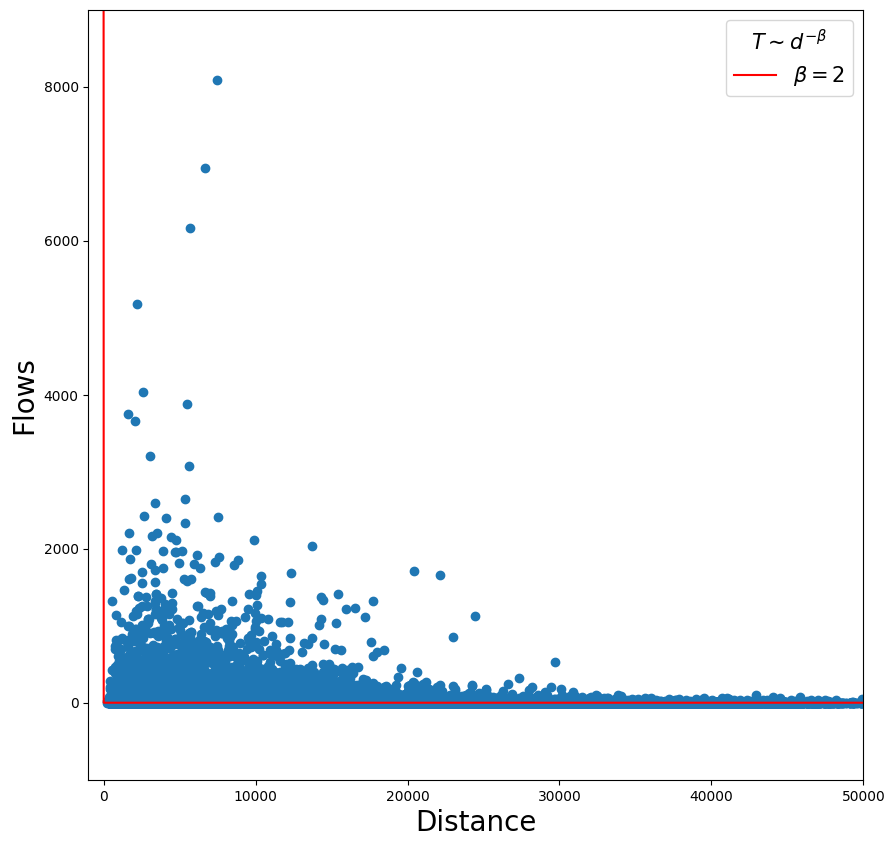

In [125]:
#first plot the Total commuter flows denoted by T against distance denoted by d
#and then fit a model line T ~ d^-beta with beta=2

#set the base axis
fig, ax = plt.subplots(figsize=(10,10))

#scatter plot
ax.scatter(x = london_OD_AMpeak["distance"], y=london_OD_AMpeak["flows"])
#line plot
line = np.arange(0.0002, 50_000, 0.1)
ax.plot(line, line**-2, color ="r", label = "$\\beta=2$")
#add a legend
ax.legend(title = "$T \\sim d^{-\\beta}$", fontsize = 15, title_fontsize=15)
#axis limits
ax.set_xlim([-1000,50000])
ax.set_ylim([-1000, 9000])
#set the labels
ax.set_xlabel("Distance", fontsize = 20)
ax.set_ylabel("Flows", fontsize = 20)

Text(0, 0.5, 'Flows')

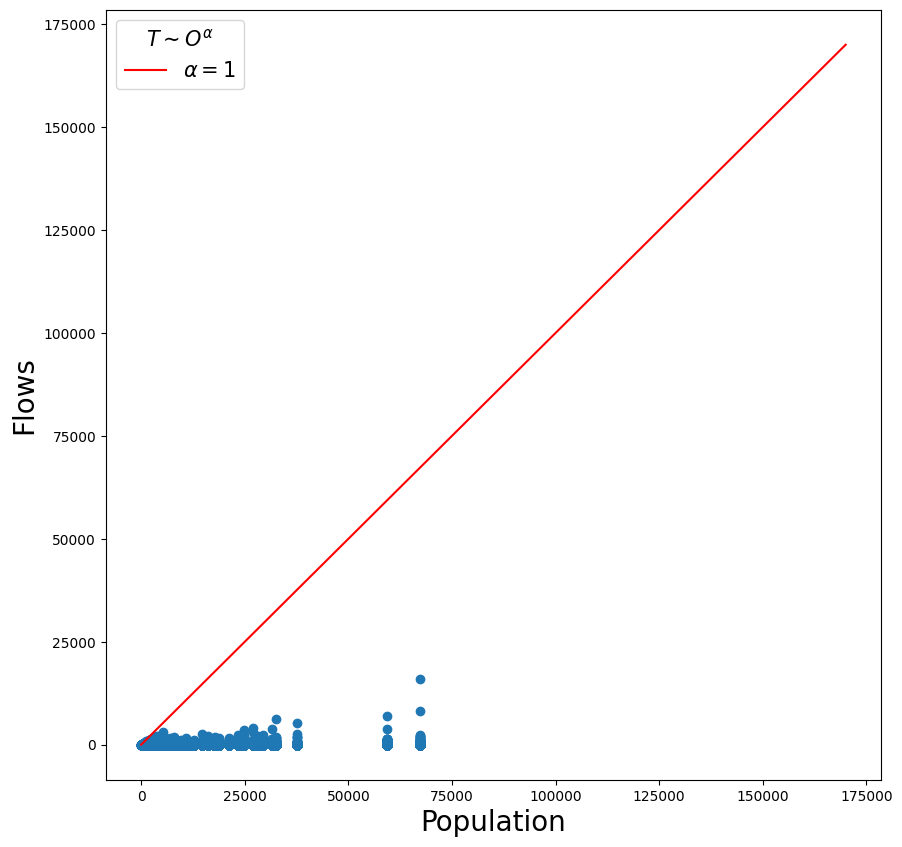

In [126]:
#Let us now look at the behaviour of the flows with respect to the population at the origin denoted by O
#and then fit a model line T ~ O^alpha, for alpha=1

#set the base axis
fig, ax = plt.subplots(figsize=(10,10))

#scatter plot
ax.scatter(x = london_OD_AMpeak["population"], y=london_OD_AMpeak["flows"])
#line plot
line = np.arange(0.0002, 170_000, 0.1)
ax.plot(line, line**1, color ="r", label = "$\\alpha=1$")
#add a legend
ax.legend( fontsize = 15, title = "$T \sim O^{\\alpha}$", title_fontsize=15)
#axis labels
ax.set_xlabel("Population", fontsize = 20)
ax.set_ylabel("Flows", fontsize = 20)

Text(0, 0.5, 'Flows')

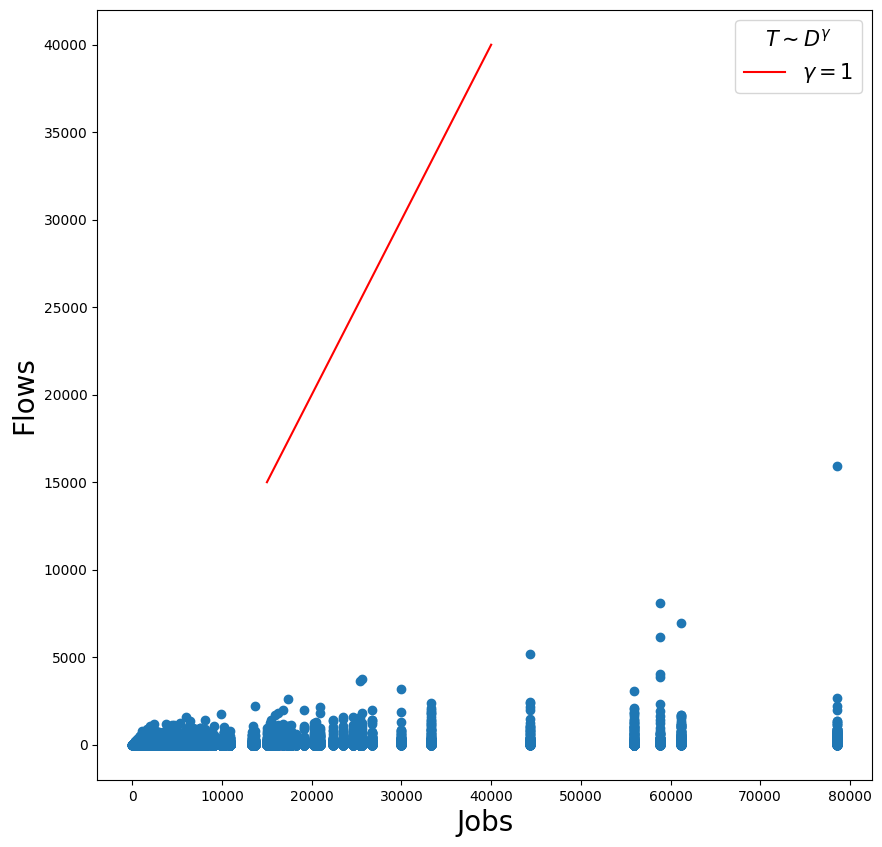

In [127]:
#Now let us look at the behaviour of the flows with respect to the salaries at destination denoted by D
# and then fit a model line  T ~ D^gamma. We will fit a line for gamma=1

#set the base axis
fig, ax = plt.subplots(figsize=(10,10))

#scatter plot
ax.scatter(x = london_OD_AMpeak["jobs"], y=london_OD_AMpeak["flows"])
#line plot
line = np.arange(15_000, 40000, 0.1)
ax.plot(line, line**1, color ="r", label = "$\\gamma=1$")
#add a legend
ax.legend( fontsize = 15, title = "$T \sim D^{\\gamma}$", title_fontsize=15)
#axis labels
ax.set_xlabel("Jobs", fontsize = 20)
ax.set_ylabel("Flows", fontsize = 20)

In [128]:
#create the formula (the "-1" indicates no intercept in the regression model).
formula = 'flows ~ station_origin + log_jobs + log_distance-1'
#run a production constrained sim
prodSim = smf.glm(formula = formula, data=london_OD_AMpeak, family=sm.families.Poisson()).fit()
#let's have a look at it's summary
print(prodSim.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  flows   No. Observations:                61456
Model:                            GLM   Df Residuals:                    61055
Model Family:                 Poisson   Df Model:                          400
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.0168e+06
Date:                Fri, 05 May 2023   Deviance:                   1.8614e+06
Time:                        16:21:24   Pearson chi2:                 2.78e+06
No. Iterations:                    26   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                                  coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

Text(0, 0.5, 'log(Total)')

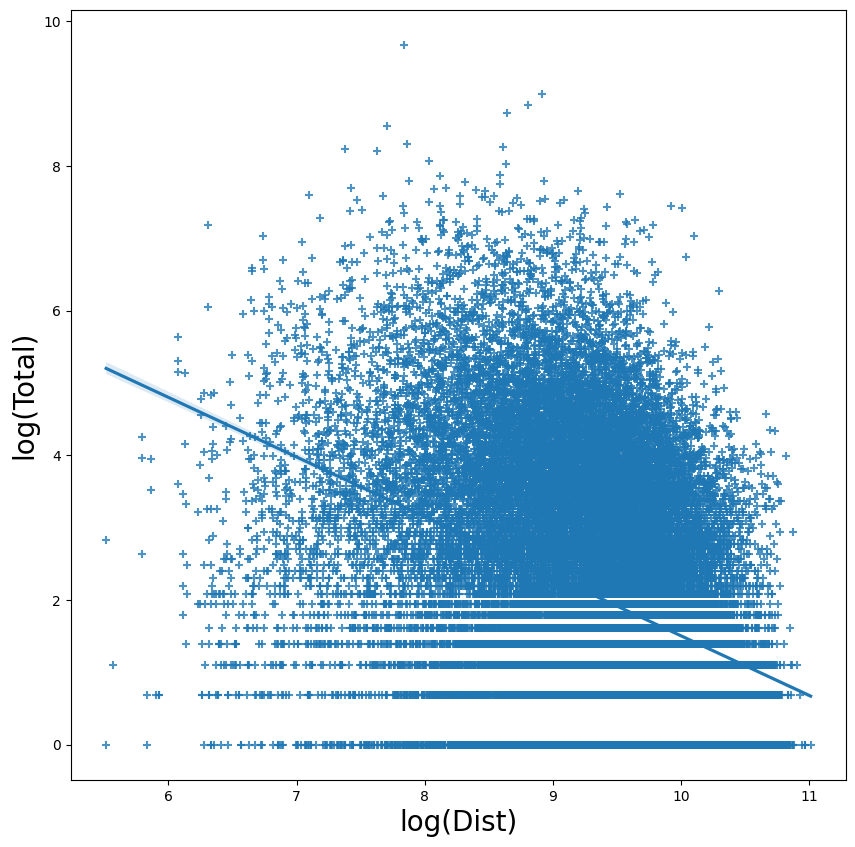

In [129]:
#subset the dataframe to the flows we want
cdata_flows = london_OD_AMpeak[["flows", "distance"]]
#remove all 0 values (logarithms can't deal with 0 values)
cdata_flows = cdata_flows[(cdata_flows!=0).all(1)]

#extract the x and y converting to log
x = np.log(cdata_flows["distance"])
y = np.log(cdata_flows["flows"])

#create the subplot
fig, ax = plt.subplots(figsize = (10,10))
#plot the results along with the line of best fit
sns.regplot(x=x, y=y, marker="+", ax=ax)
ax.set_xlabel("log(Dist)", fontsize = 20)
ax.set_ylabel("log(Total)", fontsize = 20)

In [130]:
#create some Oi and Dj columns in the dataframe and store row and column totals in them:
#to create O_i, take cdatasub ...then... group by origcodenew ...then... summarise by calculating the sum of Total
O_i = pd.DataFrame(london_OD_AMpeak.groupby(["station_origin"])["flows"].agg(np.sum))
O_i.rename(columns={"flows":"O_i"}, inplace = True)
london_OD_AMpeak = london_OD_AMpeak.merge(O_i, on = "station_origin", how = "left" )

D_j = pd.DataFrame(london_OD_AMpeak.groupby(["station_destination"])["flows"].agg(np.sum))
D_j.rename(columns={"flows":"D_j"}, inplace = True)
london_OD_AMpeak = london_OD_AMpeak.merge(D_j, on = "station_destination", how = "left" )

In [131]:
#We can do this by pulling out the parameter values
coefs = pd.DataFrame(prodSim.params)
coefs.reset_index(inplace=True)
coefs.rename(columns = {0:"alpha_i", "index":"coef"}, inplace = True)
to_repl = ["(station_origin)", "\[", "\]"]
for x in to_repl:
    coefs["coef"] = coefs["coef"].str.replace(x, "")
#then once you have done this you can join them back into the dataframes
london_OD_AMpeak = london_OD_AMpeak.merge(coefs, left_on="station_origin", right_on="coef", how = "left")
london_OD_AMpeak.drop(columns = ["coef"], inplace = True)
#check this has worked
london_OD_AMpeak.head()

<ipython-input-131-5dc38f2fc5b2>:7: FutureWarning: The default value of regex will change from True to False in a future version.
  coefs["coef"] = coefs["coef"].str.replace(x, "")


,station_origin,station_destination,flows,population,jobs,distance,FlowsNoIntra,log_population,log_jobs,log_distance,O_i,D_j,alpha_i
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,0,6.39693,11.271491,9.003627,599,78549,3.251612
1,Abbey Road,Beckton,1,599,442,8510.121774,1,6.39693,6.093570,9.049129,599,442,3.251612
2,Abbey Road,Blackwall,3,599,665,3775.448872,3,6.39693,6.501290,8.236539,599,665,3.251612
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,1,6.39693,10.981438,8.534545,599,58772,3.251612
4,Abbey Road,Canning Town,37,599,15428,2228.923167,37,6.39693,9.644004,7.709722,599,15428,3.251612


In [132]:
alpha_i = prodSim.params[0:399]
gamma = prodSim.params[399]
beta = -prodSim.params[400]

In [133]:
alpha_i

station_origin[Abbey Road]          3.251612
station_origin[Acton Central]       5.018479
station_origin[Acton Town]          4.564536
station_origin[Aldgate]             3.325187
station_origin[Aldgate East]        3.459054
                                      ...   
station_origin[Wood Street]         5.243521
station_origin[Woodford]            5.162363
station_origin[Woodgrange Park]     5.256153
station_origin[Woodside Park]       4.700381
station_origin[Woolwich Arsenal]    6.907034
Length: 399, dtype: float64

In [134]:
gamma

0.7688381958454191

In [135]:
london_OD_AMpeak["prodsimest1"] = np.exp(london_OD_AMpeak["alpha_i"]+gamma*london_OD_AMpeak["log_jobs"] 
                                 - beta*london_OD_AMpeak["log_distance"])
#or you could do it the easy way like we did last week with the fitted column (See previous practical)
london_OD_AMpeak.head(10)

,station_origin,station_destination,flows,population,jobs,distance,FlowsNoIntra,log_population,log_jobs,log_distance,O_i,D_j,alpha_i,prodsimest1
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,0,6.39693,11.271491,9.003627,599,78549,3.251612,55.017649
1,Abbey Road,Beckton,1,599,442,8510.121774,1,6.39693,6.093570,9.049129,599,442,3.251612,0.986784
2,Abbey Road,Blackwall,3,599,665,3775.448872,3,6.39693,6.501290,8.236539,599,665,3.251612,2.756734
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,1,6.39693,10.981438,8.534545,599,58772,3.251612,66.469998
4,Abbey Road,Canning Town,37,599,15428,2228.923167,37,6.39693,9.644004,7.709722,599,15428,3.251612,49.063111
5,Abbey Road,Crossharbour,1,599,1208,6686.475560,1,6.39693,7.097549,8.807992,599,1208,3.251612,2.639101
6,Abbey Road,Custom House,0,599,845,3824.855630,0,6.39693,6.740519,8.249537,599,845,3.251612,3.275782
7,Abbey Road,Cutty Sark,2,599,1748,8503.898909,2,6.39693,7.466799,9.048398,599,1748,3.251612,2.838086
8,Abbey Road,Cyprus,7,599,850,6532.099618,7,6.39693,6.746412,8.784637,599,850,3.251612,2.056466
9,Abbey Road,Devons Road,1,599,611,3958.324171,1,6.39693,6.416732,8.283829,599,611,3.251612,2.478097


In [136]:
#first round the estimates
london_OD_AMpeak["prodsimest1"] = round(london_OD_AMpeak["prodsimest1"],0)
#now we can create a pivot tabel to turn the paired list into a matrix, and compute the margins as well
OD2 = london_OD_AMpeak.pivot_table(values ="prodsimest1", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)
OD2

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,599.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1223.0
Acton Town,NaN,NaN,NaN,18.0,18.0,NaN,9.0,1.0,NaN,20.0,...,16.0,3.0,5.0,13.0,NaN,2.0,NaN,2.0,NaN,3749.0
Aldgate,NaN,NaN,2.0,NaN,47.0,NaN,NaN,0.0,NaN,21.0,...,4.0,NaN,3.0,2.0,NaN,1.0,NaN,1.0,NaN,2882.0
Aldgate East,NaN,NaN,2.0,52.0,NaN,NaN,1.0,0.0,NaN,23.0,...,5.0,1.0,3.0,2.0,NaN,1.0,NaN,1.0,NaN,3169.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,7.0,35.0,39.0,NaN,NaN,NaN,NaN,32.0,...,15.0,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,4868.0
Woodgrange Park,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,532.0
Woodside Park,NaN,NaN,5.0,20.0,20.0,NaN,2.0,NaN,NaN,25.0,...,11.0,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,3092.0


In [137]:
OD

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,32,599
Acton Central,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1224
Acton Town,0,0,0,3,17,0,35,0,0,11,...,77,3,6,9,0,0,0,0,0,3745
Aldgate,0,0,0,0,0,0,0,0,0,17,...,0,0,4,8,0,0,0,0,0,2886
Aldgate East,0,0,2,0,0,0,0,0,0,20,...,24,0,0,12,0,1,0,1,0,3172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,0,0,2,5,47,0,0,0,0,22,...,2,0,1,0,0,0,0,0,0,4868
Woodgrange Park,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,530
Woodside Park,0,0,1,26,11,0,0,0,0,59,...,0,0,0,0,0,0,0,0,0,3093


In [138]:
CalcRSquared(london_OD_AMpeak["flows"], london_OD_AMpeak["prodsimest1"])

0.3883843221088982

In [139]:
CalcRMSE(london_OD_AMpeak["flows"], london_OD_AMpeak["prodsimest1"])

102.849

**Checking the data**

In [140]:
london_OD_AMpeak[london_OD_AMpeak.population==0]

,station_origin,station_destination,flows,population,jobs,distance,FlowsNoIntra,log_population,log_jobs,log_distance,O_i,D_j,alpha_i,prodsimest1
3795,Battersea Park,Brockley,0,0,468,13201.698809,0,0.0,6.150603,9.488177,0,468,-21.081638,0.0
3796,Battersea Park,Canada Water,0,0,20443,10440.366798,0,0.0,9.925445,9.253531,0,20443,-21.081638,0.0
3797,Battersea Park,Clapham High Street,0,0,1296,1790.459591,0,0.0,7.167809,7.490786,0,1296,-21.081638,0.0
3798,Battersea Park,Dalston Junction,0,0,1289,17192.960480,0,0.0,7.162397,9.752313,0,1289,-21.081638,0.0
3799,Battersea Park,Denmark Hill,0,0,2612,5032.444704,0,0.0,7.868254,8.523860,0,2612,-21.081638,0.0
3800,Battersea Park,Forest Hill,0,0,608,16194.083957,0,0.0,6.411818,9.692463,0,608,-21.081638,0.0
3801,Battersea Park,Hackney Central,0,0,2440,21027.763711,0,0.0,7.800163,9.953646,0,2440,-21.081638,0.0
3802,Battersea Park,Haggerston,0,0,1184,16384.952185,0,0.0,7.077498,9.704180,0,1184,-21.081638,0.0
3803,Battersea Park,Homerton,0,0,1998,21110.011316,0,0.0,7.600402,9.957550,0,1998,-21.081638,0.0
3804,Battersea Park,Honor Oak Park,0,0,341,14936.019983,0,0.0,5.834811,9.611598,0,341,-21.081638,0.0


In [141]:
london_OD_AMpeak[london_OD_AMpeak.distance==0]

,station_origin,station_destination,flows,population,jobs,distance,FlowsNoIntra,log_population,log_jobs,log_distance,O_i,D_j,alpha_i,prodsimest1


In [142]:
london_OD_AMpeak[london_OD_AMpeak.flows==0]

,station_origin,station_destination,flows,population,jobs,distance,FlowsNoIntra,log_population,log_jobs,log_distance,O_i,D_j,alpha_i,prodsimest1
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,0,6.396930,11.271491,9.003627,599,78549,3.251612,55.0
6,Abbey Road,Custom House,0,599,845,3824.855630,0,6.396930,6.740519,8.249537,599,845,3.251612,3.0
14,Abbey Road,Lewisham,0,599,2400,11213.451494,0,6.396930,7.783641,9.324959,599,2400,3.251612,3.0
18,Abbey Road,Poplar,0,599,1301,4498.407430,0,6.396930,7.171657,8.411701,599,1301,3.251612,4.0
31,Acton Central,Barking,0,1224,7004,28856.336866,0,7.110696,8.854379,10.270120,1224,7004,5.018479,17.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61414,Woodside Park,Willesden Junction,0,3093,4165,20911.927138,0,8.037220,8.334712,9.948123,3093,4165,4.700381,11.0
61415,Woodside Park,Wimbledon,0,3093,6295,28247.311360,0,8.037220,8.747670,10.248789,3093,6295,4.700381,11.0
61416,Woodside Park,Wood Green,0,3093,2146,21624.176790,0,8.037220,7.671827,9.981614,3093,2146,4.700381,6.0
61433,Woolwich Arsenal,Island Gardens,0,7892,691,12483.746818,0,8.973732,6.539586,9.432263,7892,691,6.907034,38.0


In [143]:
london_OD_AMpeak[london_OD_AMpeak.jobs==0]

,station_origin,station_destination,flows,population,jobs,distance,FlowsNoIntra,log_population,log_jobs,log_distance,O_i,D_j,alpha_i,prodsimest1
7044,Brockley,Battersea Park,0,2322,0,13201.698809,0,7.750615,0.0,9.488177,2322,0,5.772869,0.0
8517,Canada Water,Battersea Park,0,27026,0,10440.366798,0,10.204592,0.0,9.253531,27026,0,5.932045,0.0
11568,Clapham High Street,Battersea Park,0,1500,0,1790.459591,0,7.313887,0.0,7.490786,1500,0,5.681129,0.0
13684,Dalston Junction,Battersea Park,0,3912,0,17192.960480,0,8.272060,0.0,9.752313,3912,0,5.665700,0.0
13964,Denmark Hill,Battersea Park,0,1844,0,5032.444704,0,7.520235,0.0,8.523860,1844,0,5.643800,0.0
19129,Forest Hill,Battersea Park,0,2430,0,16194.083957,0,7.796058,0.0,9.692463,2430,0,6.102383,0.0
21726,Hackney Central,Battersea Park,0,3370,0,21027.763711,0,8.122965,0.0,9.953646,3370,0,5.554863,0.0
21897,Haggerston,Battersea Park,0,2049,0,16384.952185,0,7.625595,0.0,9.704180,2049,0,4.966234,0.0
26640,Honor Oak Park,Battersea Park,0,1750,0,14936.019983,0,7.467942,0.0,9.611598,1750,0,5.664115,0.0
27425,Hoxton,Battersea Park,0,1041,0,15550.373547,0,6.948897,0.0,9.651904,1041,0,4.256043,0.0


In [144]:
london_OD_AMpeak[london_OD_AMpeak.station_destination=='Canary Wharf']

,station_origin,station_destination,flows,population,jobs,distance,FlowsNoIntra,log_population,log_jobs,log_distance,O_i,D_j,alpha_i,prodsimest1
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,1,6.396930,10.981438,8.534545,599,58772,3.251612,66.0
126,Acton Town,Canary Wharf,57,3745,58772,20398.165882,57,8.228444,10.981438,9.923249,3745,58772,4.564536,73.0
348,Aldgate,Canary Wharf,1,2886,58772,6564.419680,1,7.967973,10.981438,8.789572,2886,58772,3.325187,57.0
595,Aldgate East,Canary Wharf,3,3172,58772,5127.998899,3,8.062433,10.981438,8.542666,3172,58772,3.459054,81.0
817,All Saints,Canary Wharf,67,740,58772,1340.088733,67,6.608001,10.981438,7.201237,740,58772,3.381889,244.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60577,Wood Green,Canary Wharf,64,6667,58772,16849.246595,64,8.805075,10.981438,9.732121,6667,58772,5.139635,153.0
60820,Wood Lane,Canary Wharf,0,1088,58772,17092.091760,0,6.993015,10.981438,9.746430,1088,58772,3.156232,21.0
61044,Woodford,Canary Wharf,192,4868,58772,13963.787075,192,8.490644,10.981438,9.544294,4868,58772,5.162363,185.0
61276,Woodside Park,Canary Wharf,42,3093,58772,22356.567178,42,8.037220,10.981438,10.014920,3093,58772,4.700381,77.0


# **SCENÁRIOS**

## **Scenário 1**

Assume that Canary Wharf has a 50% decrease in jobs after Brexit. Using the calibrated parameter , compute the new flows for scenario A. Make sure the number of commuters is conserved, and explain how you ensured this.

In [145]:
def new_jobs(row):
    if row["station_destination"] == "Canary Wharf":
        val = 58772*0.5
    else:
        val = row["jobs"]
    return val
        
london_OD_AMpeak["Jobs_A"] = london_OD_AMpeak.apply(new_jobs, axis =1)
london_OD_AMpeak.head(10)

,station_origin,station_destination,flows,population,jobs,distance,FlowsNoIntra,log_population,log_jobs,log_distance,O_i,D_j,alpha_i,prodsimest1,Jobs_A
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,0,6.39693,11.271491,9.003627,599,78549,3.251612,55.0,78549.0
1,Abbey Road,Beckton,1,599,442,8510.121774,1,6.39693,6.093570,9.049129,599,442,3.251612,1.0,442.0
2,Abbey Road,Blackwall,3,599,665,3775.448872,3,6.39693,6.501290,8.236539,599,665,3.251612,3.0,665.0
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,1,6.39693,10.981438,8.534545,599,58772,3.251612,66.0,29386.0
4,Abbey Road,Canning Town,37,599,15428,2228.923167,37,6.39693,9.644004,7.709722,599,15428,3.251612,49.0,15428.0
5,Abbey Road,Crossharbour,1,599,1208,6686.475560,1,6.39693,7.097549,8.807992,599,1208,3.251612,3.0,1208.0
6,Abbey Road,Custom House,0,599,845,3824.855630,0,6.39693,6.740519,8.249537,599,845,3.251612,3.0,845.0
7,Abbey Road,Cutty Sark,2,599,1748,8503.898909,2,6.39693,7.466799,9.048398,599,1748,3.251612,3.0,1748.0
8,Abbey Road,Cyprus,7,599,850,6532.099618,7,6.39693,6.746412,8.784637,599,850,3.251612,2.0,850.0
9,Abbey Road,Devons Road,1,599,611,3958.324171,1,6.39693,6.416732,8.283829,599,611,3.251612,2.0,611.0


In [146]:
london_OD_AMpeak[london_OD_AMpeak.station_destination=='Canary Wharf'].head()

,station_origin,station_destination,flows,population,jobs,distance,FlowsNoIntra,log_population,log_jobs,log_distance,O_i,D_j,alpha_i,prodsimest1,Jobs_A
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,1,6.396930,10.981438,8.534545,599,58772,3.251612,66.0,29386.0
126,Acton Town,Canary Wharf,57,3745,58772,20398.165882,57,8.228444,10.981438,9.923249,3745,58772,4.564536,73.0,29386.0
348,Aldgate,Canary Wharf,1,2886,58772,6564.419680,1,7.967973,10.981438,8.789572,2886,58772,3.325187,57.0,29386.0
595,Aldgate East,Canary Wharf,3,3172,58772,5127.998899,3,8.062433,10.981438,8.542666,3172,58772,3.459054,81.0,29386.0
817,All Saints,Canary Wharf,67,740,58772,1340.088733,67,6.608001,10.981438,7.201237,740,58772,3.381889,244.0,29386.0


In [147]:
london_OD_AMpeak["prodsimest2"] = np.exp(london_OD_AMpeak["alpha_i"]+gamma*np.log(london_OD_AMpeak["Jobs_A"]) - beta*london_OD_AMpeak["log_distance"])

london_OD_AMpeak["prodsimest2"] = round(london_OD_AMpeak["prodsimest2"],0)
#now we can convert the pivot table into a matrix
OD3 = london_OD_AMpeak.pivot_table(values ="prodsimest2", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)
OD3

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,572.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1223.0
Acton Town,NaN,NaN,NaN,18.0,18.0,NaN,9.0,1.0,NaN,20.0,...,16.0,3.0,5.0,13.0,NaN,2.0,NaN,2.0,NaN,3719.0
Aldgate,NaN,NaN,2.0,NaN,47.0,NaN,NaN,0.0,NaN,21.0,...,4.0,NaN,3.0,2.0,NaN,1.0,NaN,1.0,NaN,2858.0
Aldgate East,NaN,NaN,2.0,52.0,NaN,NaN,1.0,0.0,NaN,23.0,...,5.0,1.0,3.0,2.0,NaN,1.0,NaN,1.0,NaN,3136.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,7.0,35.0,39.0,NaN,NaN,NaN,NaN,32.0,...,15.0,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,4790.0
Woodgrange Park,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,532.0
Woodside Park,NaN,NaN,5.0,20.0,20.0,NaN,2.0,NaN,NaN,25.0,...,11.0,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,3060.0


In [148]:
#compare to the last one

OD2

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,599.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1223.0
Acton Town,NaN,NaN,NaN,18.0,18.0,NaN,9.0,1.0,NaN,20.0,...,16.0,3.0,5.0,13.0,NaN,2.0,NaN,2.0,NaN,3749.0
Aldgate,NaN,NaN,2.0,NaN,47.0,NaN,NaN,0.0,NaN,21.0,...,4.0,NaN,3.0,2.0,NaN,1.0,NaN,1.0,NaN,2882.0
Aldgate East,NaN,NaN,2.0,52.0,NaN,NaN,1.0,0.0,NaN,23.0,...,5.0,1.0,3.0,2.0,NaN,1.0,NaN,1.0,NaN,3169.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,7.0,35.0,39.0,NaN,NaN,NaN,NaN,32.0,...,15.0,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,4868.0
Woodgrange Park,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,532.0
Woodside Park,NaN,NaN,5.0,20.0,20.0,NaN,2.0,NaN,NaN,25.0,...,11.0,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,3092.0


In [149]:
#calculate some new Dj^gamma and d_ij^beta values
Dj2_gamma = london_OD_AMpeak["jobs"]**gamma
dist_beta = london_OD_AMpeak["distance"]**-beta
#calcualte the first stage of the Ai values
london_OD_AMpeak["Ai1"] = Dj2_gamma * dist_beta
#now do the sum over all js bit
A_i = pd.DataFrame(london_OD_AMpeak.groupby(["station_origin"])["Ai1"].agg(np.sum))
#now divide into 1
A_i["Ai1"] = 1/A_i["Ai1"]
A_i.rename(columns={"Ai1":"A_i"}, inplace=True)
#and write the A_i values back into the dataframe
london_OD_AMpeak = london_OD_AMpeak.merge(A_i, left_on="station_origin", right_index=True, how="left")

In [150]:
#to check everything works, recreate the original estimates
london_OD_AMpeak["prodsimest3"] = london_OD_AMpeak["A_i"]*london_OD_AMpeak["O_i"]*Dj2_gamma*dist_beta
#round
london_OD_AMpeak["prodsimest3"] = round(london_OD_AMpeak["prodsimest3"])
#check
london_OD_AMpeak[["prodsimest1", "prodsimest3"]]

,prodsimest1,prodsimest3
0,55.0,55.0
1,1.0,1.0
2,3.0,3.0
3,66.0,66.0
4,49.0,49.0
...,...,...
61451,121.0,121.0
61452,259.0,259.0
61453,32.0,32.0
61454,98.0,98.0


In [151]:
#calculate some new Dj^gamma and d_ij^beta values
Dj3_gamma = london_OD_AMpeak["Jobs_A"]**gamma
#calcualte the first stage of the Ai values
london_OD_AMpeak["Ai1"] = Dj3_gamma * dist_beta
#now do the sum over all js bit
A_i = pd.DataFrame(london_OD_AMpeak.groupby(["station_origin"])["Ai1"].agg(np.sum))
#now divide into 1
A_i["Ai1"] = 1/A_i["Ai1"]
A_i.rename(columns={"Ai1":"A_i2"}, inplace=True)
#and write the A_i values back into the dataframe
london_OD_AMpeak = london_OD_AMpeak.merge(A_i, left_on="station_origin", right_index=True, how="left")

In [152]:
#to check everything works, recreate the original estimates
london_OD_AMpeak["prodsimest4"] = london_OD_AMpeak["A_i2"]*london_OD_AMpeak["O_i"]*Dj3_gamma*dist_beta
#round
london_OD_AMpeak["prodsimest4"] = round(london_OD_AMpeak["prodsimest4"])

In [153]:
OD4 = london_OD_AMpeak.pivot_table(values ="prodsimest4", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)
OD4

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,601.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1223.0
Acton Town,NaN,NaN,NaN,18.0,18.0,NaN,9.0,1.0,NaN,20.0,...,17.0,3.0,5.0,13.0,NaN,2.0,NaN,2.0,NaN,3744.0
Aldgate,NaN,NaN,2.0,NaN,47.0,NaN,NaN,0.0,NaN,22.0,...,4.0,NaN,3.0,2.0,NaN,1.0,NaN,1.0,NaN,2885.0
Aldgate East,NaN,NaN,2.0,53.0,NaN,NaN,1.0,0.0,NaN,23.0,...,5.0,1.0,3.0,2.0,NaN,1.0,NaN,1.0,NaN,3168.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,7.0,36.0,39.0,NaN,NaN,NaN,NaN,33.0,...,16.0,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,4863.0
Woodgrange Park,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,532.0
Woodside Park,NaN,NaN,5.0,21.0,21.0,NaN,2.0,NaN,NaN,25.0,...,11.0,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,3091.0


In [154]:
OD3

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,572.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1223.0
Acton Town,NaN,NaN,NaN,18.0,18.0,NaN,9.0,1.0,NaN,20.0,...,16.0,3.0,5.0,13.0,NaN,2.0,NaN,2.0,NaN,3719.0
Aldgate,NaN,NaN,2.0,NaN,47.0,NaN,NaN,0.0,NaN,21.0,...,4.0,NaN,3.0,2.0,NaN,1.0,NaN,1.0,NaN,2858.0
Aldgate East,NaN,NaN,2.0,52.0,NaN,NaN,1.0,0.0,NaN,23.0,...,5.0,1.0,3.0,2.0,NaN,1.0,NaN,1.0,NaN,3136.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,7.0,35.0,39.0,NaN,NaN,NaN,NaN,32.0,...,15.0,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,4790.0
Woodgrange Park,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,532.0
Woodside Park,NaN,NaN,5.0,20.0,20.0,NaN,2.0,NaN,NaN,25.0,...,11.0,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,3060.0


## **Scenário 2**

Assume that there is a significant increase in the cost of transport. Select 2 values for the parameter in the cost function reflecting scenario B. Recompute the distribution of flows